### Hands On Machine Learning With Sckikit-learn , Keras and Tensorflow

### Chapter 2 
#### End to End Machine Learning Project

#### Use California Census data to build a model of housing prices

    Our approach
    (1) Problem Definition
    (2) Data
    (3) Evaluation
    (4) Features
    (5) Modelling
    (6) Experimentation

### (1) Problem Definition

Given clinical parameters about a patient can we predict whether or not they have heart disease ?
GIven demographic parameters about the Housing prices in th California region , 
can we predict the median housing price in any district ?
The model''s output will be fed to another system(not in consederation for this problem) which will determine if the invstement in that area is worthy or not

### (2) Data
Data is available in 'https://github.com/ageron/handson-ml2/tree/master/datasets/housing'

### (3) Evaluation

### (4) Features
RangeIndex: 20640 entries, 0 to 20639

Data columns (total 10 columns):

    (1) longitude           LOngitude of the hosue location  

    (2) latitude            Latitude of the house location

    (3) housing_median_age  Median Age of the house

    (4) total_rooms         Total number of rooms in the house

    (5) total_bedrooms      Total number of bedrooms in th house

    (6) population          Population in the specific area 

    (7) households          Total number of households, a group of people residing within a home unit, for a block

    (8) median_income       Median income for households within a block of houses (measured in tens of thousands of US Dollars) 

    (9) median_house_value  Median house value for households within a block (measured in US Dollars) 

    (10) ocean_proximity     Location of the house w.r.t ocean/sea 


In [4]:
import os 
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer

In [19]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [20]:
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    os.makedirs(housing_path,exist_ok=True)
    tgz_path = os.path.join(housing_path,"hosuing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [24]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [22]:
fetch_housing_data()

In [25]:
house = load_housing_data()
house.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [26]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
house.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

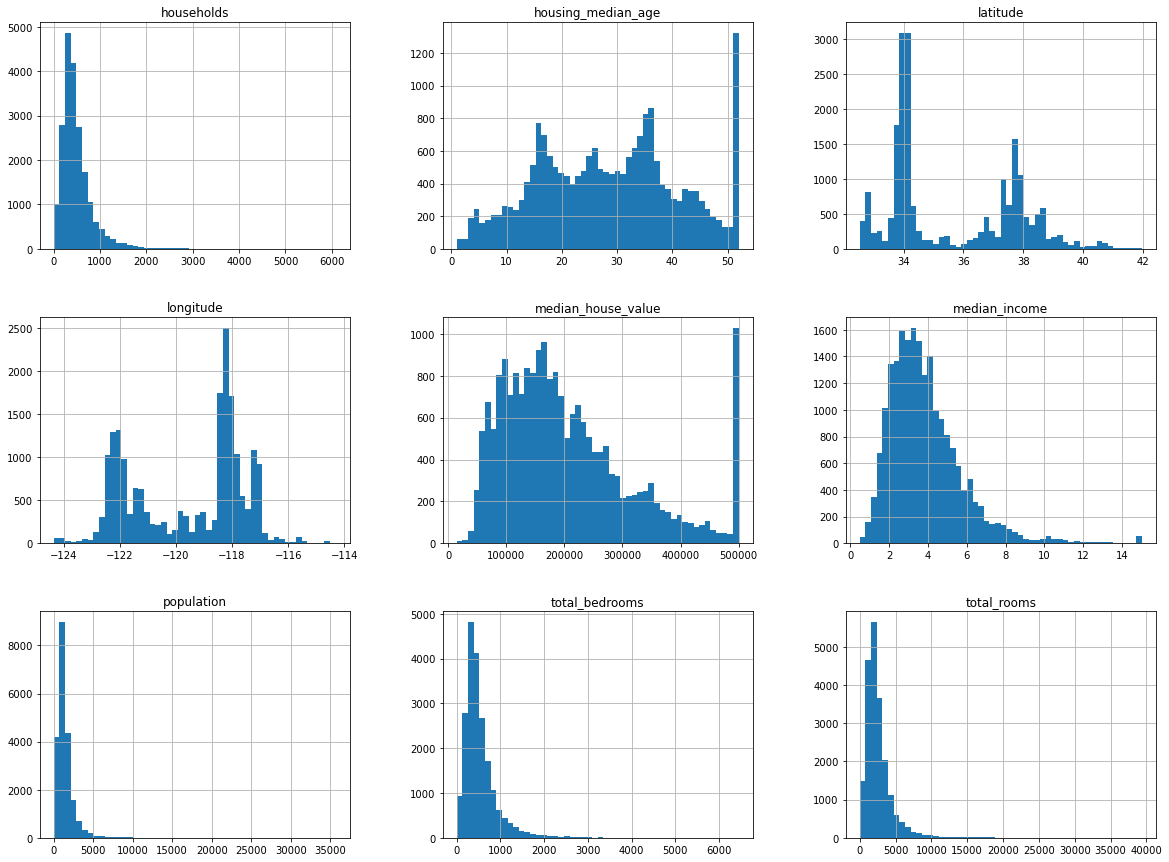

In [31]:
house.hist(bins=50,figsize=(20,15))
plt.show()

We need to split the data into train and test set, before splitting we will consider adding a new column based on the median imcome which is an important parameter in the data set, add a categorical column to the datset based on the income levels

In [32]:
house["income_cat"] = pd.cut(house["median_income"],bins=[0,1.5,3.0,4.5,6,np.inf],labels=[1,2,3,4,5])

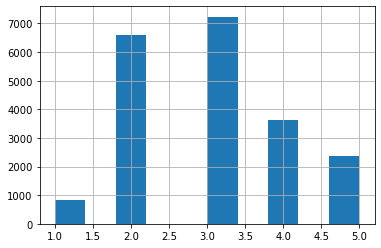

In [34]:
house["income_cat"].hist()
plt.show()

We will use a StratifiedShuffleSplit based on the income category column, as we cannot doa random split, which will vary each time we attempt a split, 
The Split being done should be based on valid parameters and not random, In this way we will try to ensure fair split of data points so that train and test set will be having all varities of data points

In [35]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(house,house["income_cat"]):
    strat_train_set = house.loc[train_index]
    strat_test_set = house.loc[test_index]

In [37]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [42]:
## Looking for Corelation
corr = house.corr()

corr.style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


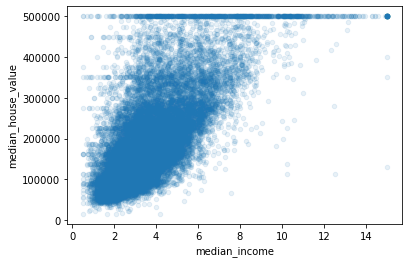

In [44]:
house.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)
plt.show()

In [45]:
house = strat_train_set.drop("median_house_value",axis=1)
house_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [46]:
imputer = SimpleImputer(strategy = "median")
house_num = house.drop("ocean_proximity",axis=1)

In [47]:
imputer.fit(house_num)

SimpleImputer(strategy='median')

In [48]:
X = imputer.transform(house_num)

In [49]:
house_tr = pd.DataFrame(X,columns=house_num.columns,index=house_num.index)

We will consider converting the categorical column into numerical column based on the Ordinal encoder of Scikit learn

In [52]:
house_cat = house[["ocean_proximity"]]

In [56]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
house_cat_encoded = ordinal_encoder.fit_transform(house_cat)

In [57]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
house_onehot = cat_encoder.fit_transform(house_cat)
house_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
house_extra_attribs = attr_adder.transform(house.values)

In [60]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    house.columns.get_loc(c) for c in col_names] # get the column indices

In [61]:
house_extra_attribs = pd.DataFrame(
    house_extra_attribs,
    columns=list(house.columns)+["rooms_per_household", "population_per_household"],
    index=house.index)
house_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


In [62]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

house_num_tr = num_pipeline.fit_transform(house_num)

In [63]:
from sklearn.compose import ColumnTransformer

num_attribs = list(house_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

house_prepared = full_pipeline.fit_transform(house)

### (5) Modelling 

In [64]:
##linear regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(house_prepared,house_labels)

LinearRegression()

In [65]:
## Decision Tree Regreessor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(house_prepared,house_labels)

DecisionTreeRegressor()

In [72]:
def display_scores(scores):
    print("Scores", scores)
    print("Mean", scores.mean())
    print("SD",scores.std())
    

In [73]:
## Cross Validation using Tree regressor
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,house_prepared,house_labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores [69639.91658352 69572.10906661 70899.84413522 68422.69945363
 72127.46720845 76214.19830439 70726.41108177 71337.5091114
 74853.07214628 67588.07141426]
Mean 71138.12985055443
SD 2559.016243863481


In [78]:
## Cross validation using Linear regression
Lin_scores = cross_val_score(lin_reg,house_prepared,house_labels,scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-Lin_scores)
display_scores(lin_rmse_scores)

Scores [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean 68828.99948449331
SD 2662.761570610344


In [80]:
## Cross validation using Random forest regression
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(house_prepared,house_labels)

forest_scores = cross_val_score(forest_reg,house_prepared,house_labels,scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores [49569.66224746 47285.882116   49614.05916066 51859.35195627
 50023.46776919 53348.25387531 49077.28436205 48031.40928284
 53457.44485117 50087.50128269]
Mean 50235.431690363745
SD 1962.2226013695529


In [87]:
model_scores = [['Lin_Reg',lin_rmse_scores.mean(),lin_rmse_scores.std()],['Dec_tree_reg',tree_rmse_scores.mean(),tree_rmse_scores.std()],
                    ['Random_forest',forest_rmse_scores.mean(),forest_rmse_scores.std()]]
df_model_scores = pd.DataFrame(model_scores,columns=['Model','Means','STD'])
df_model_scores

,Model,Means,STD
0,Lin_Reg,68828.999484,2662.761571
1,Dec_tree_reg,71138.129851,2559.016244
2,Random_forest,50235.431690,1962.222601


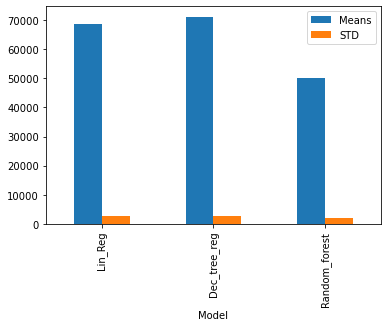

In [88]:
df_model_scores.plot(kind='bar',x='Model')
plt.show()

## Improving Model Accuracy

In [89]:
## We can improve our model using grid search CV
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(house_prepared, house_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [90]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [94]:
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value",axis=1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(Y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49040.18609727207

### (6) Exprementation

In [100]:
## Attempting Support Vector Machine
from sklearn.model_selection  import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(house_prepared, house_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   5.4s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   5.4s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.7s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.4s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   5.3s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   5.4s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   5.3s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=  11.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  11.7s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.7s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=   9.9s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   9.1s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  10.0s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   9.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=  10.4s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   9.0s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   8.9s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   9.0s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   9.0s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   8.9s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   9.1s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=  12.9s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   8.7s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   8.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.6s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.7s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.7s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 38.2min finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [102]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70338.36756805143

In [103]:
grid_search.best_params_

{'C': 1000.0, 'kernel': 'linear'}